In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import unet
from unet import utils
from unet.datasets import circles

In [7]:
train_dataset, validation_dataset = circles.load_data(100, nx=256, ny=256, splits=(0.7, 0.3))

In [8]:
from tensorflow.python import ipu

cfg = ipu.config.IPUConfig()
cfg.auto_select_ipus = 1
cfg.configure_ipu_system()

In [9]:
with ipu.ipu_strategy.IPUStrategy(enable_dataset_iterators=False).scope():
    unet_model = unet.build_model(channels=circles.channels,
                                  num_classes=circles.classes,
                                  layer_depth=3,
                                  filters_root=16)
    unet.finalize_model(unet_model)
    
    trainer = unet.Trainer(checkpoint_callback=False)    
    trainer.fit(unet_model,
                train_dataset,
                validation_dataset,
                epochs=5,
                batch_size=1)
    
    prediction = unet_model.predict(validation_dataset.batch(batch_size=3, drop_remainder=True))

Epoch 1/5


ValueError: in user code:

    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/ipu/keras/extensions/keras_extension_base.py:569 train_function  *
        outfeed.enqueue(self.train_step(next(iterator)))
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:752 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /nethome/alext/venvs/poplar_sdk-ubuntu_18_04-2.4.0+856-d16ca54529/2.4.0+856_tf2/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (1, 160, 160, 2) and (1, 216, 216, 2) are incompatible


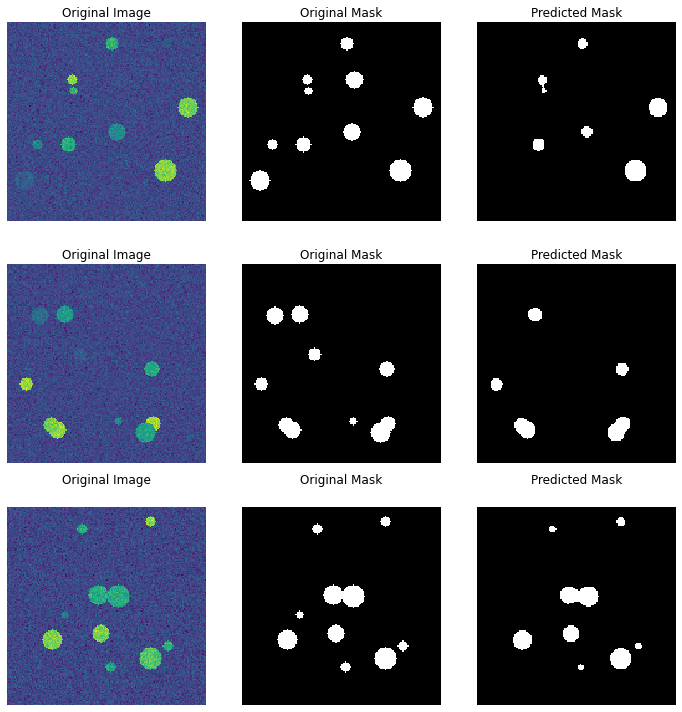

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()